# 03 - Modelagem de Previsão de Demanda

Este notebook treina e avalia modelos de previsão (RandomForest e SARIMA).

RandomForest - RMSE: 56.91, MAE: 33.82, MAPE: 37.23%, SMAPE: 21.51%
XGBoost - RMSE: 5.09, MAE: 3.77, MAPE: 4.90%, SMAPE: 7.03%
SARIMA - RMSE: 140.95, MAE: 109.33, MAPE: 518.24%, SMAPE: 60.45%


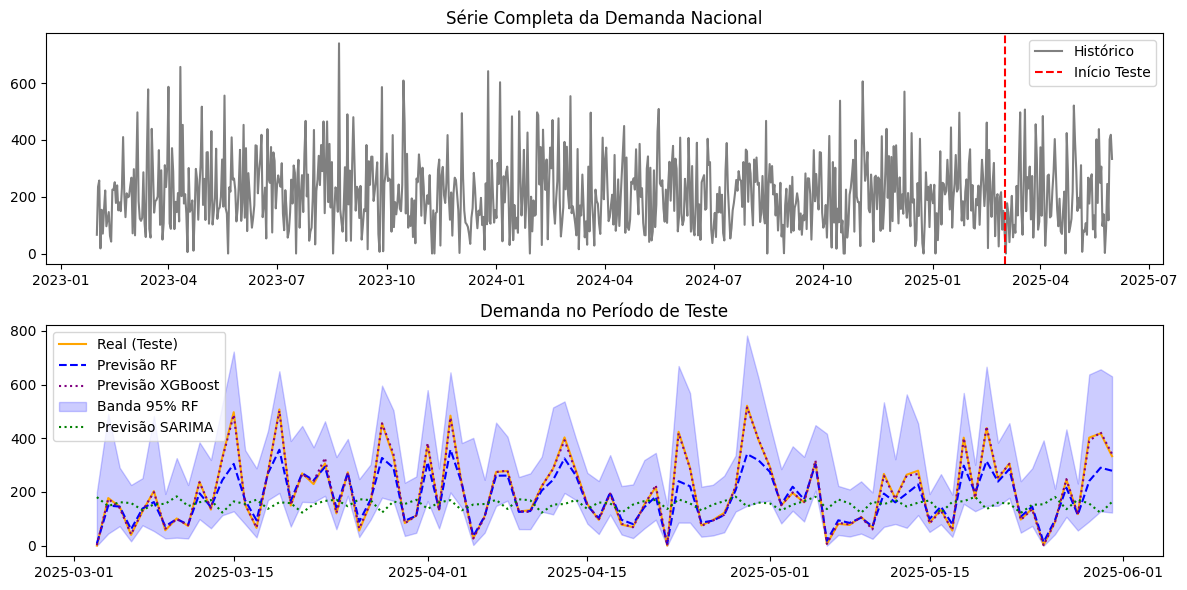

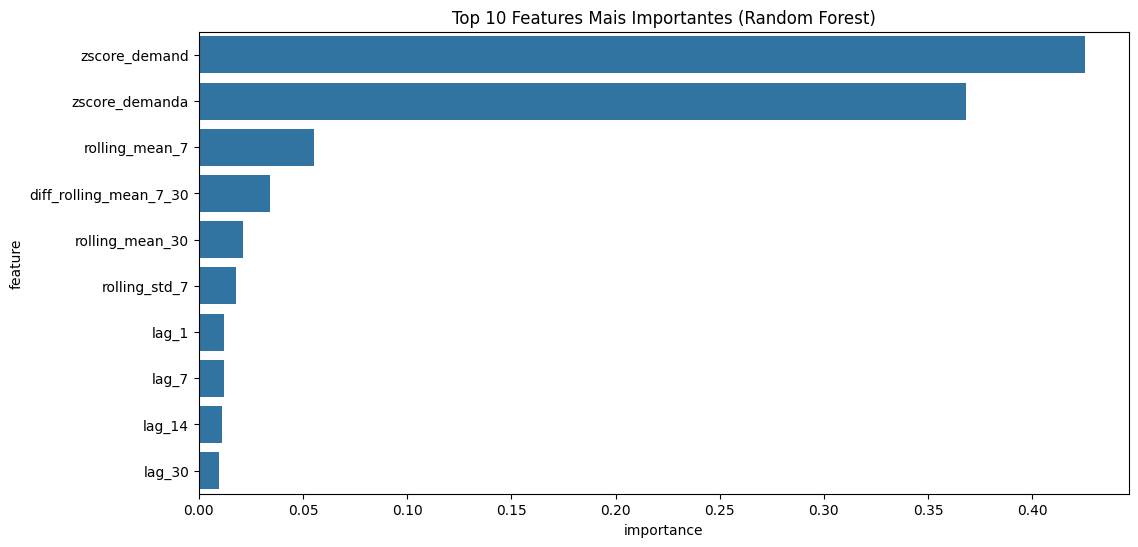


RF - Teste de Normalidade Shapiro-Wilk:
Shapiro-Wilk p-value = 0.0000 → Não normal


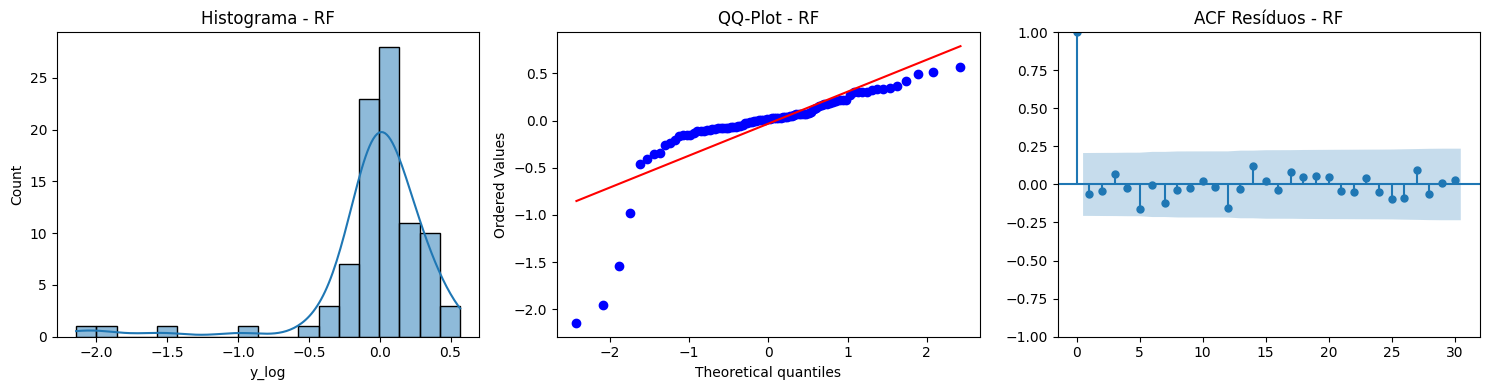


XGBoost - Teste de Normalidade Shapiro-Wilk:
Shapiro-Wilk p-value = 0.0000 → Não normal


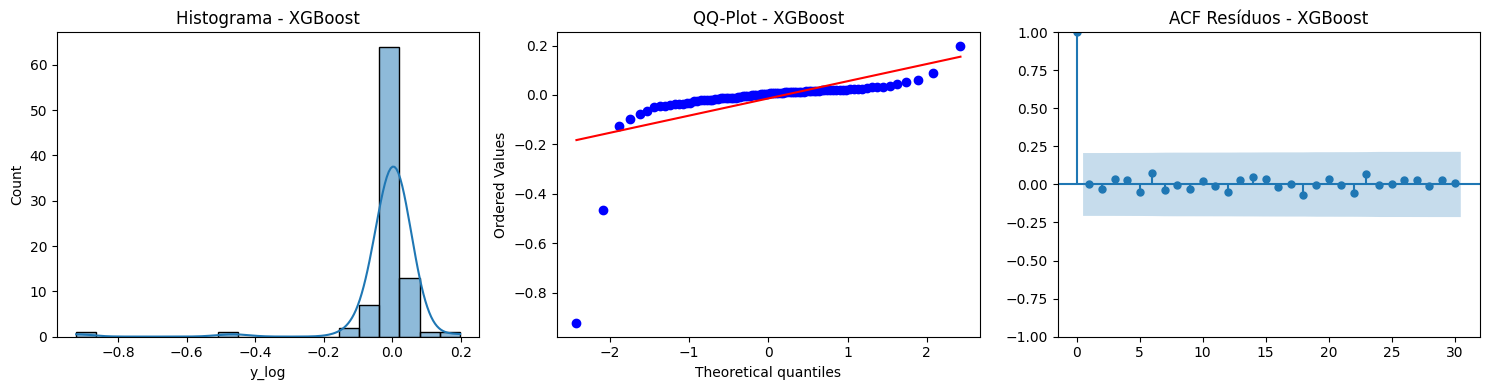


SARIMA - Teste de Normalidade Shapiro-Wilk:
Shapiro-Wilk p-value = 0.0000 → Não normal


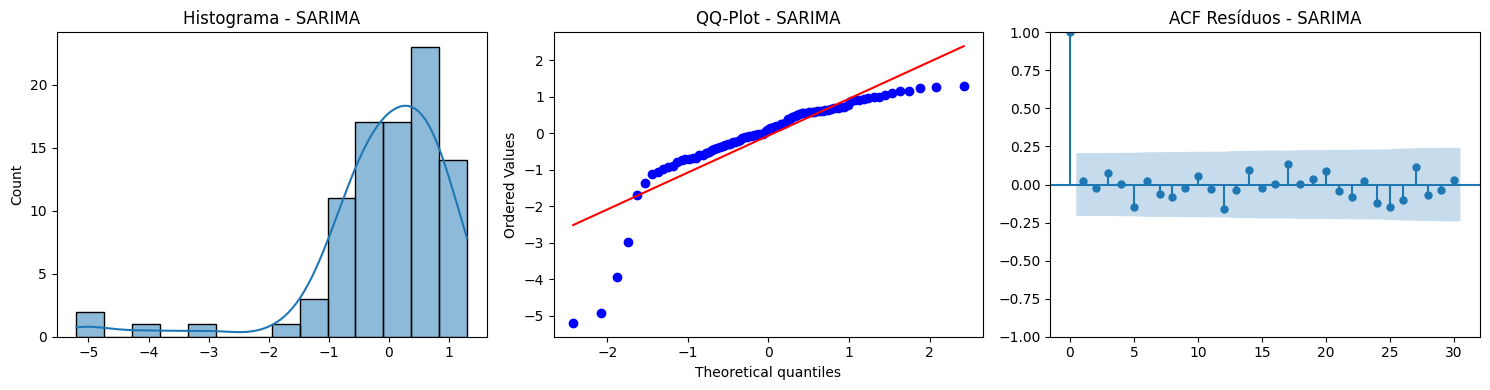

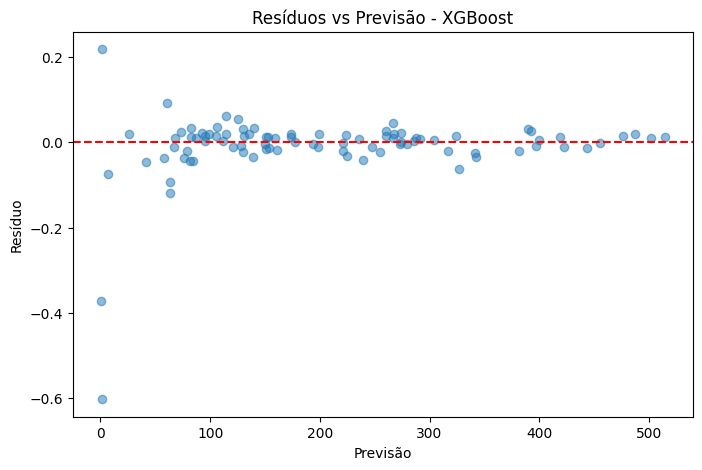

c:\Users\breno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Resultados da Validação Cruzada Temporal (MAPE):
Random Forest - Média: 67.51%, Desvio Padrão: 63.70%
XGBoost - Média: 10.11%, Desvio Padrão: 8.05%
SARIMA - Média: 426.29%, Desvio Padrão: 262.39%


<Figure size 1200x600 with 0 Axes>

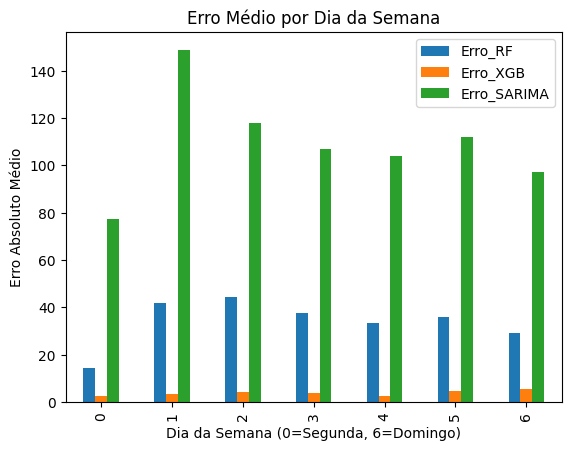

<Figure size 1200x600 with 0 Axes>

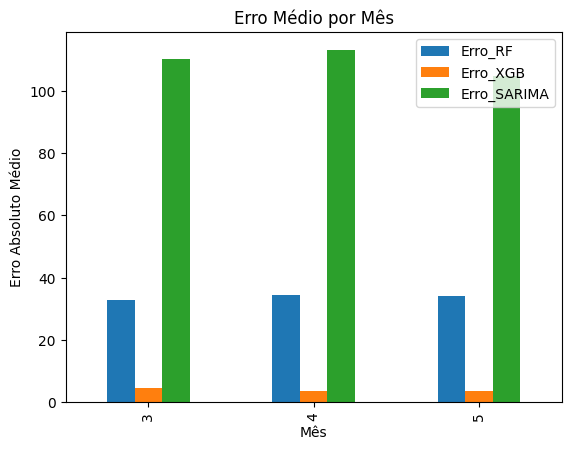

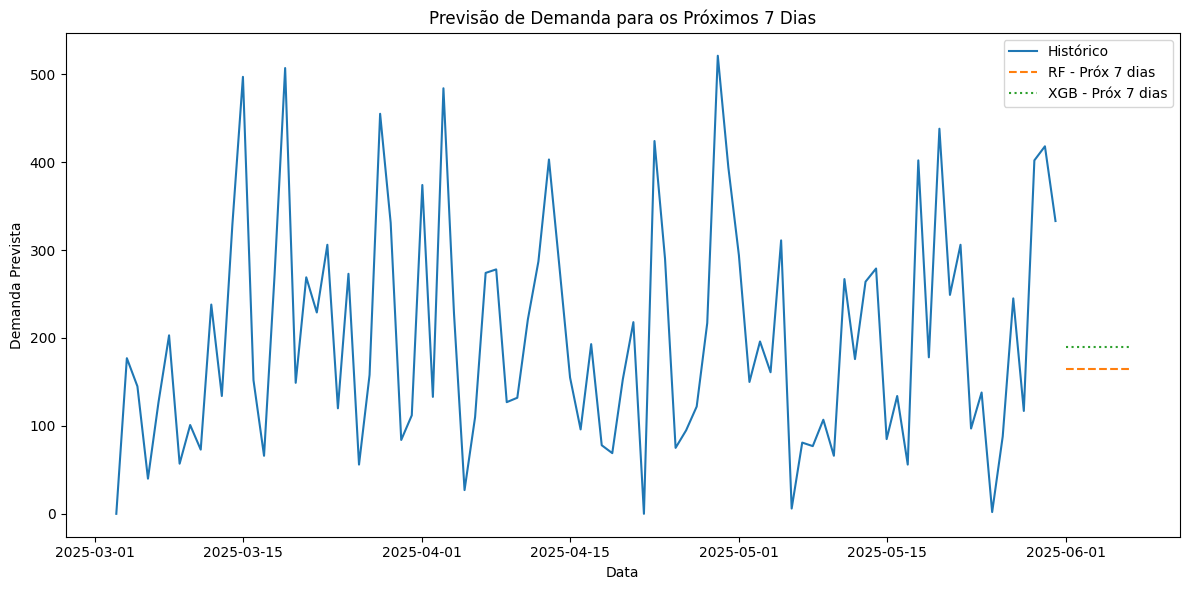

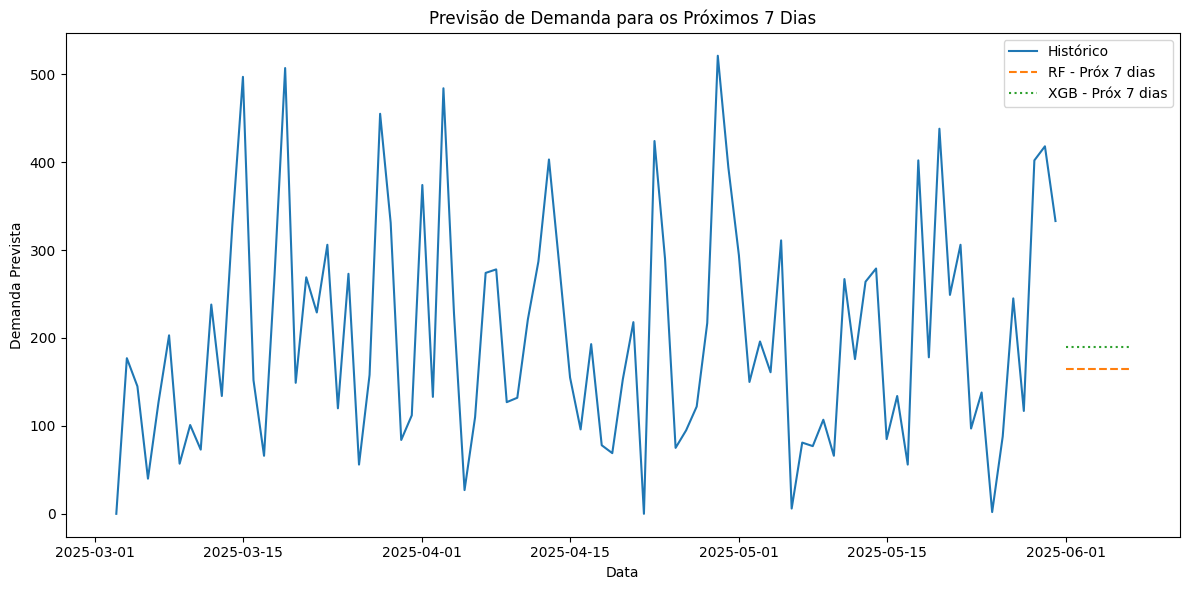

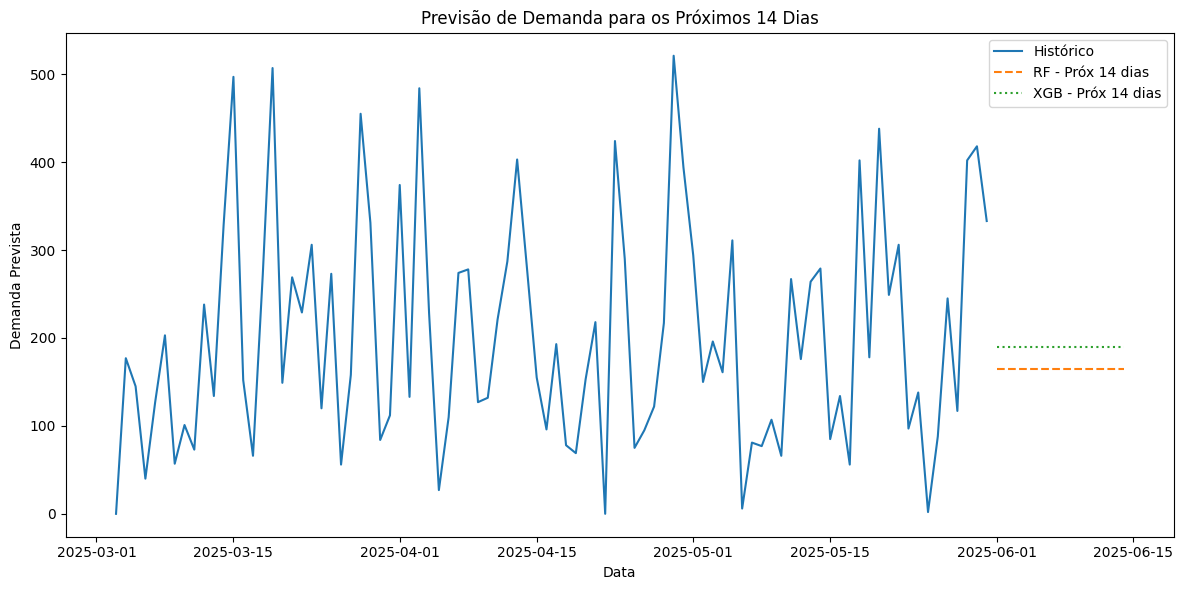

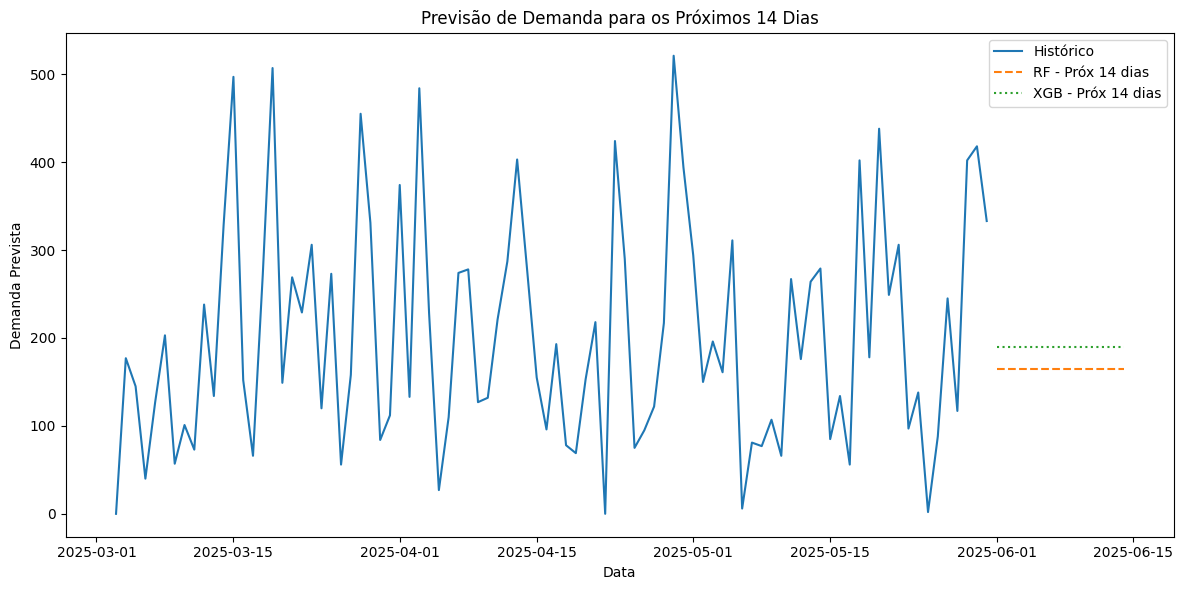

In [18]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import shapiro
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

# Funções de erro
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Carregar dados
demanda_features = pd.read_csv("../data/processed/demanda_features.csv", parse_dates=["date"])
demanda_features = demanda_features.set_index("date").asfreq('D')

# Adicionar transformações para reduzir overfitting
demanda_features['zscore_demand'] = (demanda_features['y'] - demanda_features['y'].mean()) / demanda_features['y'].std()
demanda_features['is_outlier'] = (np.abs(demanda_features['zscore_demand']) > 3).astype(int)
demanda_features['y_log'] = np.log1p(demanda_features['y'])

# Separar target e features
y = demanda_features["y_log"]
X = demanda_features.drop(columns=["y", "y_log"])

# Dividir treino/teste
num_test_days = 90
split_date = demanda_features.index.max() - pd.Timedelta(days=num_test_days)
X_train = X.loc[:split_date]
X_test = X.loc[split_date + pd.Timedelta(days=1):]
y_train = y.loc[:split_date]
y_test = y.loc[split_date + pd.Timedelta(days=1):]

# Aplicar ruído leve ao target para reduzir overfitting
y_train_noise = y_train + np.random.normal(0, y_train.std() * 0.01, size=len(y_train))

# Random Forest com regularização
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)
rf.fit(X_train.values, y_train_noise)
all_preds = np.stack([tree.predict(X_test.values) for tree in rf.estimators_], axis=1)
pred_mean_rf = all_preds.mean(axis=1)
pred_std_rf = all_preds.std(axis=1)
lower_rf = pred_mean_rf - 1.96 * pred_std_rf
upper_rf = pred_mean_rf + 1.96 * pred_std_rf

# XGBoost com regularização
xgb = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1,
    reg_lambda=1,
    objective='reg:squarederror',
    random_state=42
)
xgb.fit(X_train.values, y_train_noise)
pred_xgb = xgb.predict(X_test.values)

# SARIMA
model_sarima = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7),
                       exog=X_train[["evento_na_data"]],
                       enforce_stationarity=False, enforce_invertibility=False)
fit_sarima = model_sarima.fit(disp=False)
pred_sarima = fit_sarima.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test[["evento_na_data"]])

# Métricas
def print_metrics(name, y_true, y_pred):
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)
    print(f"{name} - RMSE: {np.sqrt(mean_squared_error(y_true_exp, y_pred_exp)):.2f}, "
          f"MAE: {mean_absolute_error(y_true_exp, y_pred_exp):.2f}, "
          f"MAPE: {mean_absolute_percentage_error(y_true_exp, y_pred_exp):.2f}%, "
          f"SMAPE: {symmetric_mean_absolute_percentage_error(y_true_exp, y_pred_exp):.2f}%")

print_metrics("RandomForest", y_test, pred_mean_rf)
print_metrics("XGBoost", y_test, pred_xgb)
print_metrics("SARIMA", y_test, pred_sarima)

# Gráfico comparativo
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
demanda_nacional = demanda_features["y"]
axs[0].plot(demanda_nacional.index, demanda_nacional.values, color='gray', label='Histórico')
axs[0].axvline(split_date, color='red', linestyle='--', label='Início Teste')
axs[0].set_title('Série Completa da Demanda Nacional')
axs[0].legend()
axs[1].plot(y_test.index, np.expm1(y_test), color='orange', label='Real (Teste)')
axs[1].plot(y_test.index, np.expm1(pred_mean_rf), '--', color='blue', label='Previsão RF')
axs[1].plot(y_test.index, np.expm1(pred_xgb), ':', color='purple', label='Previsão XGBoost')
axs[1].fill_between(y_test.index, np.expm1(lower_rf), np.expm1(upper_rf), color='blue', alpha=0.2, label='Banda 95% RF')
axs[1].plot(y_test.index, np.expm1(pred_sarima), ':', color='green', label='Previsão SARIMA')
axs[1].set_title('Demanda no Período de Teste')
axs[1].legend()
plt.tight_layout()
plt.show()

# Importância das features - Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Features Mais Importantes (Random Forest)')
plt.show()

# Análise de Resíduos
res_rf = y_test - pred_mean_rf
res_xgb = y_test - pred_xgb
res_sarima = y_test - pred_sarima

for model_name, residuos in zip(['RF', 'XGBoost', 'SARIMA'], [res_rf, res_xgb, res_sarima]):
    print(f"\n{model_name} - Teste de Normalidade Shapiro-Wilk:")
    stat, p = shapiro(residuos)
    print(f"Shapiro-Wilk p-value = {p:.4f} → {'Normal' if p > 0.05 else 'Não normal'}")
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(residuos, kde=True)
    plt.title(f"Histograma - {model_name}")
    plt.subplot(1, 3, 2)
    stats.probplot(residuos, dist="norm", plot=plt)
    plt.title(f"QQ-Plot - {model_name}")
    plt.subplot(1, 3, 3)
    plot_acf(residuos, ax=plt.gca(), lags=30)
    plt.title(f"ACF Resíduos - {model_name}")
    plt.tight_layout()
    plt.show()

# Heterocedasticidade
plt.figure(figsize=(8, 5))
plt.scatter(np.expm1(pred_xgb), np.expm1(res_xgb), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs Previsão - XGBoost")
plt.xlabel("Previsão")
plt.ylabel("Resíduo")
plt.show()

# Validação cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)
rf_scores, xgb_scores, sarima_scores = [], [], []

for train_idx, test_idx in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    rf_cv = RandomForestRegressor(n_estimators=300, max_depth=6, min_samples_leaf=5, max_features='sqrt', random_state=42)
    rf_cv.fit(X_train_cv, y_train_cv)
    pred_rf_cv = rf_cv.predict(X_test_cv)
    rf_scores.append(mean_absolute_percentage_error(np.expm1(y_test_cv), np.expm1(pred_rf_cv)))

    xgb_cv = XGBRegressor(n_estimators=500, max_depth=4, learning_rate=0.05, subsample=0.7, colsample_bytree=0.7,
                          reg_alpha=1, reg_lambda=1, objective='reg:squarederror', random_state=42)
    xgb_cv.fit(X_train_cv.values, y_train_cv)
    pred_xgb_cv = xgb_cv.predict(X_test_cv.values)
    xgb_scores.append(mean_absolute_percentage_error(np.expm1(y_test_cv), np.expm1(pred_xgb_cv)))

    model_sarima_cv = SARIMAX(y_train_cv, order=(1,1,1), seasonal_order=(1,1,1,7),
                              exog=X_train_cv[["evento_na_data"]],
                              enforce_stationarity=False, enforce_invertibility=False)
    fit_sarima_cv = model_sarima_cv.fit(disp=False)
    pred_sarima_cv = fit_sarima_cv.predict(start=X_test_cv.index[0], end=X_test_cv.index[-1],
                                           exog=X_test_cv[["evento_na_data"]])
    sarima_scores.append(mean_absolute_percentage_error(np.expm1(y_test_cv), np.expm1(pred_sarima_cv)))

print("\nResultados da Validação Cruzada Temporal (MAPE):")
print(f"Random Forest - Média: {np.mean(rf_scores):.2f}%, Desvio Padrão: {np.std(rf_scores):.2f}%")
print(f"XGBoost - Média: {np.mean(xgb_scores):.2f}%, Desvio Padrão: {np.std(xgb_scores):.2f}%")
print(f"SARIMA - Média: {np.mean(sarima_scores):.2f}%, Desvio Padrão: {np.std(sarima_scores):.2f}%")

# Erro por dia/mês
resultados = pd.DataFrame({
    'Data': y_test.index,
    'Real': np.expm1(y_test.values),
    'RF': np.expm1(pred_mean_rf),
    'XGB': np.expm1(pred_xgb),
    'SARIMA': np.expm1(pred_sarima)
})
resultados['Erro_RF'] = np.abs(resultados['Real'] - resultados['RF'])
resultados['Erro_XGB'] = np.abs(resultados['Real'] - resultados['XGB'])
resultados['Erro_SARIMA'] = np.abs(resultados['Real'] - resultados['SARIMA'])
resultados['Dia_Semana'] = resultados.index.dayofweek
resultados['Mes'] = resultados.index.month
plt.figure(figsize=(12, 6))
resultados.groupby('Dia_Semana')[['Erro_RF', 'Erro_XGB', 'Erro_SARIMA']].mean().plot(kind='bar')
plt.title('Erro Médio por Dia da Semana')
plt.xlabel('Dia da Semana (0=Segunda, 6=Domingo)')
plt.ylabel('Erro Absoluto Médio')
plt.show()
plt.figure(figsize=(12, 6))
resultados.groupby('Mes')[['Erro_RF', 'Erro_XGB', 'Erro_SARIMA']].mean().plot(kind='bar')
plt.title('Erro Médio por Mês')
plt.xlabel('Mês')
plt.ylabel('Erro Absoluto Médio')
plt.show()

# Previsão futura (7 e 14 dias) com RF e XGBoost
for dias in [7, 14]:
    future_dates = pd.date_range(start=demanda_features.index.max() + pd.Timedelta(days=1), periods=dias, freq='D')
    future_df = pd.DataFrame(index=future_dates)
    future_df = future_df.assign(**{col: 0 for col in X_train.columns})
    future_df = future_df[X_train.columns]
    pred_rf_future = rf.predict(future_df.values)
    pred_xgb_future = xgb.predict(future_df.values)
    plt.figure(figsize=(12, 6))
    plt.plot(demanda_features.index[-90:], demanda_features["y"].iloc[-90:], label="Histórico")
    plt.plot(future_dates, np.expm1(pred_rf_future), '--', label=f"RF - Próx {dias} dias")
    plt.plot(future_dates, np.expm1(pred_xgb_future), ':', label=f"XGB - Próx {dias} dias")
    plt.title(f"Previsão de Demanda para os Próximos {dias} Dias")
    plt.xlabel("Data")
    plt.ylabel("Demanda Prevista")
    plt.legend()
    plt.tight_layout()
    plt.show()

    pred_rf_future = rf.predict(future_df.values)
    pred_xgb_future = xgb.predict(future_df.values)
    plt.figure(figsize=(12, 6))
    plt.plot(demanda_features.index[-90:], demanda_features["y"].iloc[-90:], label="Histórico")
    plt.plot(future_dates, np.expm1(pred_rf_future), '--', label=f"RF - Próx {dias} dias")
    plt.plot(future_dates, np.expm1(pred_xgb_future), ':', label=f"XGB - Próx {dias} dias")
    plt.title(f"Previsão de Demanda para os Próximos {dias} Dias")
    plt.xlabel("Data")
    plt.ylabel("Demanda Prevista")
    plt.legend()
    plt.tight_layout()
    plt.show()
